In [ ]:
link = 'https://sfbay.craigslist.org/search/sfc/apa?min_bedrooms=2&min_bathrooms=2&availabilityMode=0&parking=2&sale_date=all+dates'

In [23]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
response = get(link)

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [79]:
#grab the first post
post_one = posts[0]
post_one

<li class="result-row" data-pid="7233257470" data-repost-of="6957696875">
<a class="result-image gallery" data-ids="3:00v0v_g6sbUSuAYVo_0CI0pI,3:00v0v_z43rzwwmCb_0CI0pI,3:00E0E_8wxLpSuxUnY_0CI0pI,3:00n0n_4ThY2DmyWpr_0CI0pI,3:00P0P_e10aardyn26_0CI0pI,3:00Z0Z_I0c02i77V2_0CI0pI,3:00M0M_fwwckFO1sRI_0CI0pI,3:00n0n_32gy0gxQ4PD_0CI0pI,3:00i0i_emRPqKyNsvy_0CI0pI,3:01616_gz2vkUH5cGp_0CI0pI,3:00505_6HrKSNtLGeW_0CI0pI,3:00V0V_evTdyBb9e6V_0CI0pI,3:01313_782daBppZQf_0CI0pI,3:00x0x_kcDb8xzAo1m_0CI0pI,3:00X0X_j8budSiV02O_0CI0pI,3:00i0i_lav2Gbz8NUa_0CI0pI,3:00l0l_2eXbUoia8YQ_0fk09Y,3:00c0c_8zDfkz5S5rP_0oM0hO,1:00d0d_aKt70Xeib3p" href="https://sfbay.craigslist.org/sfc/apa/d/san-francisco-rockwell-9th-floor-2bd/7233257470.html">
<span class="result-price">$3,495</span>
</a>
<div class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2020-11-18 13:52" title="Wed 18 Nov 01:52:15 PM">Nov 18</tim

In [37]:
#grab the price of the first post
post_one_price = post_one.a.text
int(post_one_price.strip().replace("$", "").replace(",", ""))
# post_price = int(post.a.text.strip().replace("$", ""))

3495

In [27]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

In [28]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [29]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element

post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]

post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[1][:-3] #cleans the ft2 at the end

In [30]:
post_one_sqft

''

In [31]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = posts[0].find('span', class_='result-hood').text

In [32]:
post_one_hood

' (pacific heights)'

In [59]:
#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:

    # https://sfbay.craigslist.org/search/sfc/apa?min_bedrooms=2&min_bathrooms=2&availabilityMode=0&parking=2&sale_date=all+dates
    #get request
    response = get("https://sfbay.craigslist.org/search/sfc/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&availabilityMode=0"
                   + "&min_bathrooms=2"
                   + '&min_bedrooms=2'
                   + '&parking=2')

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            for price in post:
                if not post.a.text.strip():
                    post_price = np.nan
                else:
                    post_price = int(post.a.text.strip().replace("$", "").replace(",", ""))
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!


Scrape complete!


In [60]:
import pandas as pd

sf_2bdr_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(sf_2bdr_apts.info())
sf_2bdr_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 7 columns):
posted             1320 non-null object
neighborhood       1320 non-null object
post title         1320 non-null object
number bedrooms    1320 non-null object
sqft               803 non-null float64
URL                1320 non-null object
price              1287 non-null float64
dtypes: float64(2), object(5)
memory usage: 72.3+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2020-11-18 13:52,(pacific heights),Rockwell 9th Floor 2bd | 2ba | 1prkg | ameniti...,2,900.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3495.0
1,2020-11-18 13:51,(SOMA / south beach),Mint Plaza Full Floor 2bd | 2ba | 1pkrg | roof...,2,1600.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4500.0
2,2020-11-18 13:51,(noe valley),Free Rent! Roof Deck! Top Floor 3BR/2BA Condo ...,3,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3600.0
3,2020-11-18 13:47,(glen park),"LARGE:4 Bedroom, 2 bath modern: Hd/floor, stor...",4,2500.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4995.0
4,2020-11-18 13:46,(SOMA / south beach),"DOGPATCH 2/2, Deck! Parking available",2,800.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2995.0
5,2020-11-18 13:46,(marina / cow hollow),TOP floor 2/2 Cow Hollow! roof deck and parkin...,2,850.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3795.0
6,2020-11-18 13:46,(SOMA / south beach),DOGPATCH 2 bdrm 2 bath- Large patio! PKG avail,2,875.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3295.0
7,2020-11-18 13:46,(SOMA / south beach),"HUGE patio, NEW construction, in unit laundry,...",2,850.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3150.0
8,2020-11-18 13:46,(SOMA / south beach),"Newer in SOMA- 2/2, in unit laundry, roof deck...",2,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2995.0
9,2020-11-18 13:44,(SOMA / south beach),"2 Bed, 2 Bath | Get 8 Weeks Free!!! | Luxury S...",2,970.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3375.0


In [61]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.
sf_2bdr_apts = sf_2bdr_apts.drop_duplicates(subset='URL')
len(sf_2bdr_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
sf_2bdr_apts['number bedrooms'] = sf_2bdr_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

sf_2bdr_apts['posted'] = pd.to_datetime(sf_2bdr_apts['posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

#titlecase them
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
#sf_2bdr_apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#sf_2bdr_apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)

#remove whitespaces
#sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].apply(lambda x: x.strip())

In [74]:
sf_2bdr_apts['neighborhood'] = sf_2bdr_apts['neighborhood'].map(lambda x: x.replace('(', ''))

/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
print(sf_2bdr_apts.info())
sf_2bdr_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 119
Data columns (total 7 columns):
posted             117 non-null datetime64[ns]
neighborhood       117 non-null object
post title         117 non-null object
number bedrooms    117 non-null float64
sqft               71 non-null float64
URL                117 non-null object
price              117 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 7.3+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2020-11-18 13:52:00,Pacific Heights,Rockwell 9th Floor 2bd | 2ba | 1prkg | ameniti...,2.0,900.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3495.0
1,2020-11-18 13:51:00,Soma,Mint Plaza Full Floor 2bd | 2ba | 1pkrg | roof...,2.0,1600.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4500.0
2,2020-11-18 13:51:00,Noe Valley,Free Rent! Roof Deck! Top Floor 3BR/2BA Condo ...,3.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3600.0
3,2020-11-18 13:47:00,Glen Park,"LARGE:4 Bedroom, 2 bath modern: Hd/floor, stor...",4.0,2500.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4995.0
4,2020-11-18 13:46:00,Soma,"DOGPATCH 2/2, Deck! Parking available",2.0,800.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2995.0
5,2020-11-18 13:46:00,Marina,TOP floor 2/2 Cow Hollow! roof deck and parkin...,2.0,850.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3795.0
6,2020-11-18 13:46:00,Soma,DOGPATCH 2 bdrm 2 bath- Large patio! PKG avail,2.0,875.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3295.0
7,2020-11-18 13:46:00,Soma,"HUGE patio, NEW construction, in unit laundry,...",2.0,850.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3150.0
8,2020-11-18 13:46:00,Soma,"Newer in SOMA- 2/2, in unit laundry, roof deck...",2.0,NaN,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,2995.0
9,2020-11-18 13:44:00,Soma,"2 Bed, 2 Bath | Get 8 Weeks Free!!! | Luxury S...",2.0,970.0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3375.0


In [84]:
sf_2bdr_apts = sf_2bdr_apts.drop(index=44).reset_index(drop=True)

In [77]:
sf_2bdr_apts.to_csv('sf_2bdr_apts', index = 0)

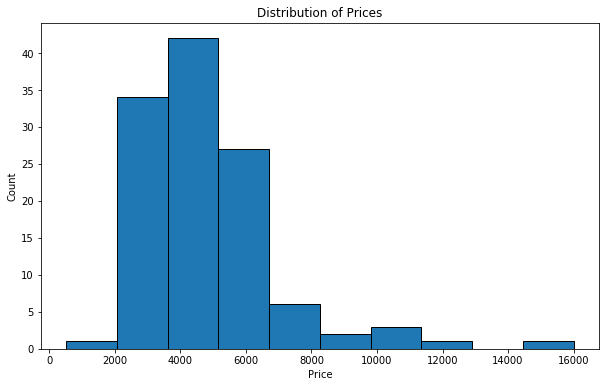

In [78]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(sf_2bdr_apts['price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices");

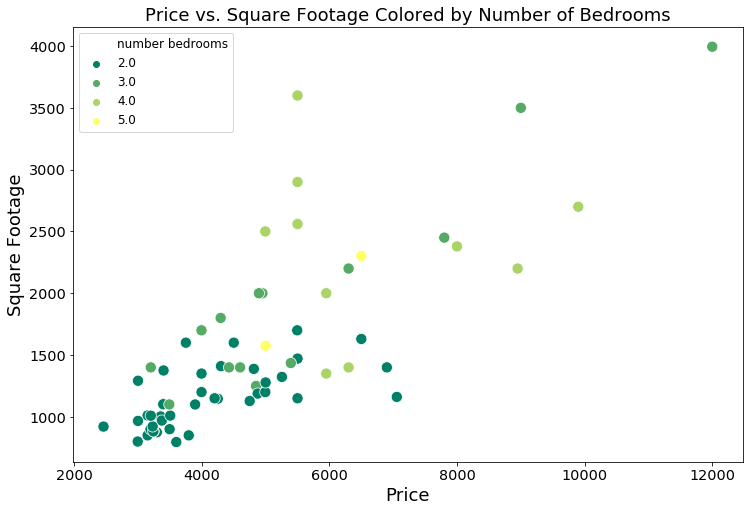

In [85]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=sf_2bdr_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

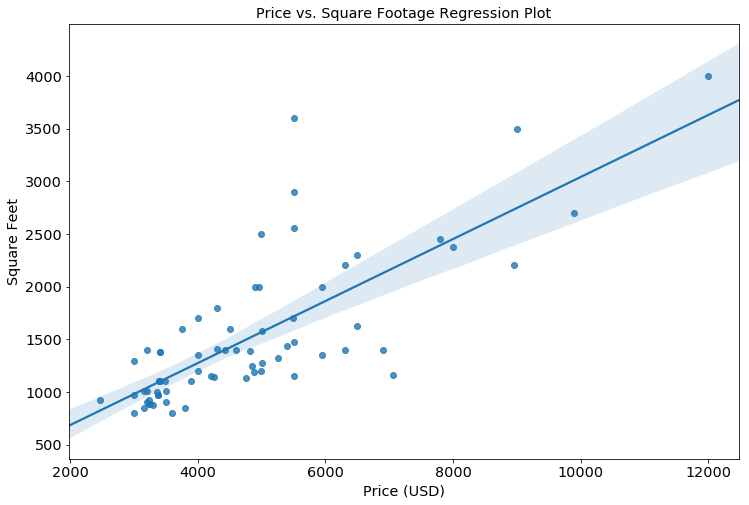

In [86]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=sf_2bdr_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [94]:
sf_2bdr_apts[['number bedrooms', 'price']].corr()

,number bedrooms,price
number bedrooms,1.000000,0.493318
price,0.493318,1.000000


In [89]:
#group by neighborhood
sf_2bdr_apts[sf_2bdr_apts['number bedrooms'] <=2].groupby('neighborhood').mean()

,number bedrooms,sqft,price
neighborhood,,,
Alamo Square,2.0,NaN,3500.000000
Castro,2.0,1100.000000,3400.000000
Dogpatch,2.0,900.000000,3195.000000
Financial District,2.0,1630.000000,6500.000000
Hayes Valley,2.0,1388.000000,4815.000000
Ingleside,2.0,967.000000,3000.000000
Lower Nob Hill,2.0,796.000000,3600.000000
Lower Pac Hts,2.0,NaN,517.000000
Marina,2.0,850.000000,4413.333333


In [90]:
#sort price to find cheapest
sf_2bdr_apts[sf_2bdr_apts['number bedrooms'] <=2].groupby('neighborhood').mean()['price'].sort_values()

neighborhood
 Lower Pac Hts          517.000000
 Ingleside             3000.000000
 Dogpatch              3195.000000
 Potrero Hill          3227.000000
 Richmond              3350.000000
 Castro                3400.000000
 Alamo Square          3500.000000
 Lower Nob Hill        3600.000000
 Mission Bay           3750.000000
 Noe Valley            3795.000000
 Soma                  3904.757576
 Sunset                4300.000000
 Marina                4413.333333
 Pacific Heights       4734.833333
 Hayes Valley          4815.000000
 Nob Hill              5058.750000
 Russian Hill          5415.666667
 Financial District    6500.000000
Name: price, dtype: float64

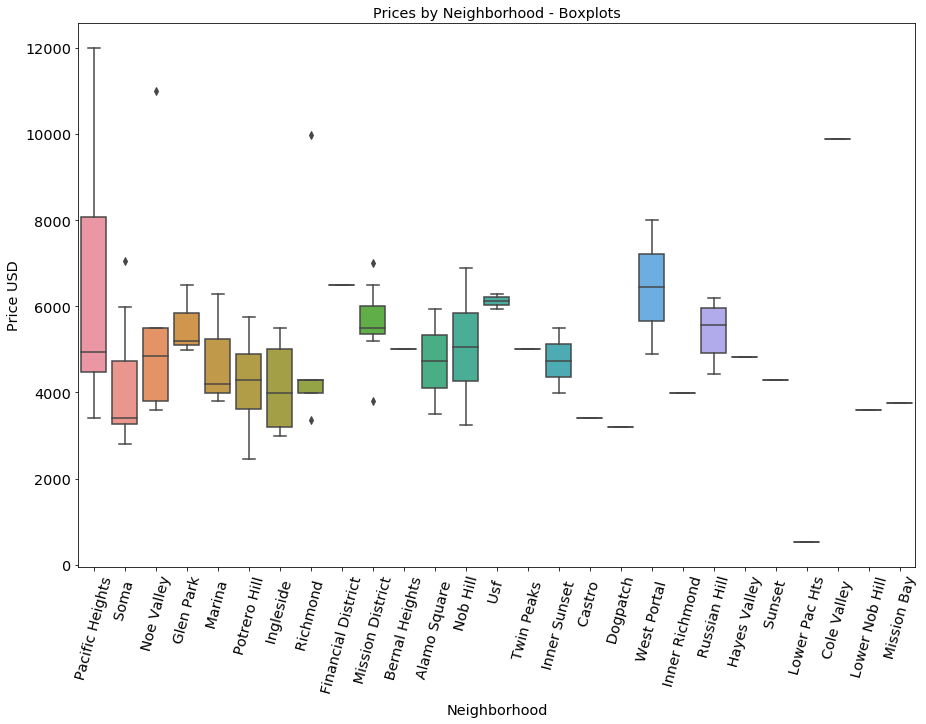

In [95]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='neighborhood', y='price', data=sf_2bdr_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");